# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [1]:
# importing our liabraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Loading Data

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('/home/ajay/Applied_course/amazon_datas/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(5)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

# Text preprocessing 

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
final_string=[]
for i, sent in enumerate(tqdm(final['Text'].values)):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
        # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    final_string.append(str1)

#############---- storing the data into .sqlite file ------########################
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

100%|██████████| 364171/364171 [05:12<00:00, 1167.09it/s]


In [13]:
final.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...


In [14]:
final.shape

(364171, 11)

In [15]:
#Taking 100k sample data 
final_sample = final[0:100000]

In [24]:
final_sample = final_sample.sort_values(by='Time')

In [16]:
final_sample.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...


# (1). Bag of Words(BoW)

In [17]:
#Breaking into Train and test
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(final_sample['CleanedText'].values,final_sample['Score'].values,test_size=0.3)

#Text -> Uni gram Vectors
bow = CountVectorizer(min_df=5,max_features=500) 
X_train = bow.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bow.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 500)
Test Data Size:  (30000, 500)


In [18]:
from sklearn.naive_bayes import MultinomialNB
from math import log

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best HyperParameter:  {'alpha': 1e-05}
Best Accuracy: 92.15%


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    1.0s finished


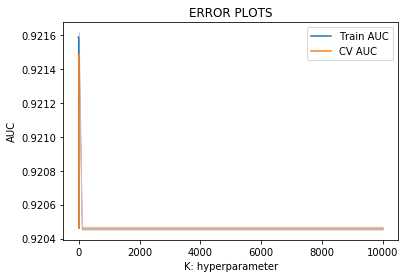

In [19]:
from sklearn.model_selection import GridSearchCV

K = [0.00001,0.0001,0.001,0.01,0.1,1,100,1000,10000]
# K = np.arange(1,500,2)

clf = MultinomialNB() 
param_grid = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,100,1000,10000]}  
gsv = GridSearchCV(clf,param_grid,cv=3,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

log_K = []

for log_value in K:
    log_K.append(log(log_value))
    
plt.plot(log_K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [20]:
#Tesing the data

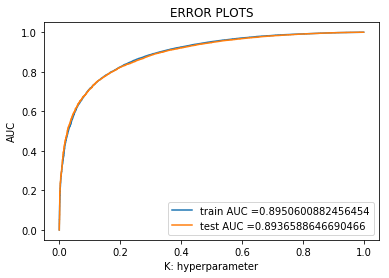

In [21]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=0.00001)
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

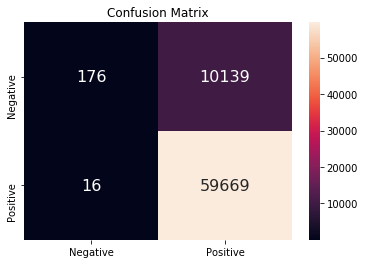

In [22]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [23]:
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.92      0.02      0.03     10315
          1       0.85      1.00      0.92     59685

avg / total       0.86      0.85      0.79     70000



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

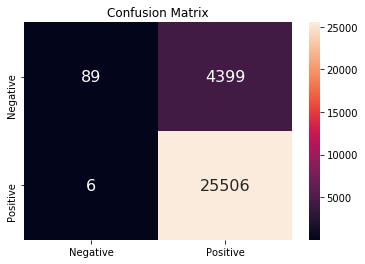

In [24]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [25]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.94      0.02      0.04      4488
          1       0.85      1.00      0.92     25512

avg / total       0.87      0.85      0.79     30000



# Feature Selection

In [26]:
# Creating the model with our best alpha.
clf = MultinomialNB(alpha = 1)
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [27]:
# Log of probabilities is gien by below function.
clf.feature_log_prob_.shape 

(2, 500)

In [28]:
# Getting feature names and log probabilities and creating a dataframe out of them.
feat_names = bow.get_feature_names()
features = pd.DataFrame(data = clf.feature_log_prob_.T,index=feat_names, columns=['Negative', 'Positive'])
features.head(10)

,Negative,Positive
abl,-6.926429,-6.534442
absolut,-6.762057,-6.503967
actual,-6.058435,-6.452522
ad,-6.417600,-6.260365
add,-6.543951,-5.578123
addict,-8.904517,-7.015148
addit,-7.265564,-7.077388
ago,-6.856436,-6.794973
almost,-6.130496,-6.472961
alreadi,-7.303564,-7.462381


In [29]:
# Sorting first on Positive column to get 10 most important words.
features.sort_values(by='Positive', ascending=False)[0:10]

,Negative,Positive
love,-5.103803,-4.056271
great,-5.428595,-4.080284
tast,-3.781765,-4.126049
like,-3.847908,-4.134377
good,-4.554829,-4.137069
tea,-4.753734,-4.286706
use,-4.648203,-4.297975
product,-3.901772,-4.330335
flavor,-4.451000,-4.361822
one,-4.275243,-4.444675


In [30]:
features.sort_values(by='Negative', ascending=False)[0:10]

,Negative,Positive
tast,-3.781765,-4.126049
like,-3.847908,-4.134377
product,-3.901772,-4.330335
one,-4.275243,-4.444675
would,-4.447347,-5.069291
flavor,-4.451000,-4.361822
tri,-4.477877,-4.561930
good,-4.554829,-4.137069
buy,-4.571491,-4.855478
order,-4.647149,-4.950459


# TF-idf

In [31]:
#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(final_sample['CleanedText'].values,final_sample['Score'].values,test_size=0.3)

tfidf = TfidfVectorizer(ngram_range=(1,2),max_features=500) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (70000, 500)
Test Data Size:  (30000, 500)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best HyperParameter:  {'alpha': 1e-05}
Best Accuracy: 92.15%


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.9s finished


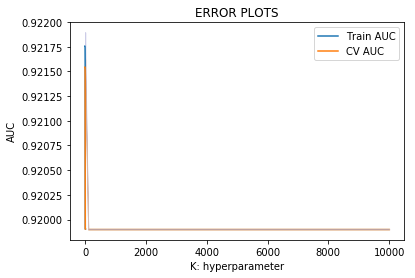

In [32]:
from sklearn.model_selection import GridSearchCV

K = [0.00001,0.0001,0.001,0.01,0.1,1,100,1000,10000]
# K = np.arange(1,500,2)

clf = MultinomialNB() 
param_grid = {'alpha':K}  
gsv = GridSearchCV(clf,param_grid,cv=3,verbose=1, scoring='f1')
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(log_K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


In [33]:
#Testing the data

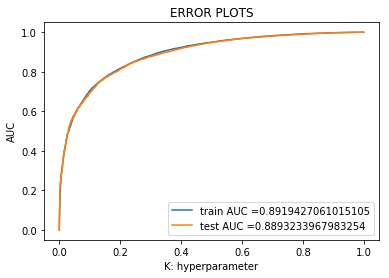

In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=0.00001)
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

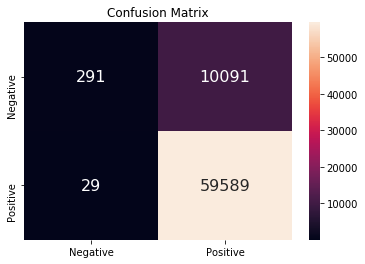

In [35]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [36]:
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.91      0.03      0.05     10382
          1       0.86      1.00      0.92     59618

avg / total       0.86      0.86      0.79     70000



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

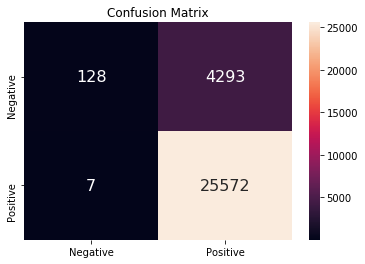

In [37]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [38]:
#Accuraccy on test data
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.95      0.03      0.06      4421
          1       0.86      1.00      0.92     25579

avg / total       0.87      0.86      0.79     30000



# Feature selection

In [39]:
# Creating the model with our best alpha.
clf = MultinomialNB(alpha = 0.1)
clf.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [40]:
# Getting feature names and log probabilities and creating a dataframe out of them.
feat_names = tfidf.get_feature_names()
features = pd.DataFrame(data = clf.feature_log_prob_.T,index=feat_names, columns=['Negative', 'Positive'])
features.head(10)


,Negative,Positive
abl,-6.855417,-6.365759
absolut,-6.645130,-6.354202
actual,-5.949956,-6.355082
ad,-6.387531,-6.219182
add,-6.595696,-5.640909
addict,-8.732788,-6.778615
addit,-7.182541,-6.910137
ago,-6.682723,-6.653248
almost,-6.014159,-6.412280
also,-5.708103,-5.379454


In [41]:
# Sorting first on Positive column to get 10 most important words.
features.sort_values(by='Positive', ascending=False)[0:10]

,Negative,Positive
tea,-4.897083,-4.431701
great,-5.880735,-4.518973
love,-5.584097,-4.520545
good,-5.010512,-4.600044
tast,-4.261304,-4.646304
like,-4.369653,-4.650992
use,-5.058662,-4.693782
product,-4.306431,-4.728681
flavor,-4.827043,-4.736731
one,-4.698445,-4.853729


So here we got probability scores of positive class for top 10 features

In [42]:
features.sort_values(by='Negative', ascending=False)[0:10]

,Negative,Positive
tast,-4.261304,-4.646304
product,-4.306431,-4.728681
like,-4.369653,-4.650992
one,-4.698445,-4.853729
would,-4.703361,-5.331320
flavor,-4.827043,-4.736731
buy,-4.846358,-5.130363
order,-4.854673,-5.152817
tri,-4.858447,-4.941218
tea,-4.897083,-4.431701


So here we got probability scores of negative class for top 10 features 

# PrettyTable

In [43]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]

x.add_row(["BOW", "Multinomial",0.00001 ,87 ])
x.add_row(["TFIDF", "Multinomial",0.00001 ,87])

print (x)

+------------+-------------+-----------------+-----+
| Vectorizer |    Model    | Hyper parameter | AUC |
+------------+-------------+-----------------+-----+
|    BOW     | Multinomial |      1e-05      |  87 |
|   TFIDF    | Multinomial |      1e-05      |  87 |
+------------+-------------+-----------------+-----+


# Feature Engineering

In [44]:
final_sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [45]:
# final_sample.head()

In [46]:
final_sample.shape

(100000, 11)

In [47]:
Filtered_data = final_sample[0:100000]

In [48]:
Filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [49]:
bow_1 = CountVectorizer(max_features=600)
X_train = bow_1.fit_transform(Filtered_data['CleanedText'].values)

In [50]:
X_train = X_train.todense()

In [51]:
print (X_train.shape)

(100000, 600)


In [52]:
length = []
for x in Filtered_data['Summary']:
    length.append(len(x))

In [53]:
type(length)

list

In [54]:
length1 = np.asarray(length)

In [55]:
length1.shape

(100000,)

In [56]:
length2 = np.reshape(length1,(100000,1))

In [57]:
# print (length2)

In [58]:
print (length2.shape)

(100000, 1)


In [59]:
print (X_train.shape)

(100000, 600)


In [60]:
Dataframe = np.hstack([X_train,length2])

In [61]:
print (len(Dataframe))

100000


In [62]:
#Breaking into Train and test
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train, X_test, y_train, y_test = train_test_split(Dataframe,Filtered_data['Score'].values,test_size=0.3)



Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   12.8s finished


Best HyperParameter:  {'alpha': 0.1}
Best Accuracy: 92.47%


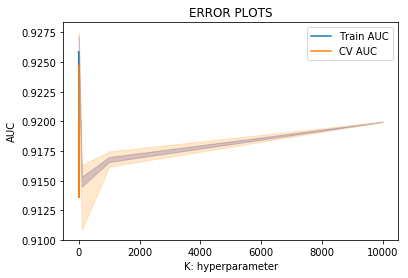

In [64]:
from sklearn.model_selection import GridSearchCV

K = [0.00001,0.0001,0.001,0.01,0.1,1,100,1000,10000]
# K = np.arange(1,40,2)

clf = MultinomialNB() 
param_grid = {'alpha':K}  
gsv = GridSearchCV(clf,param_grid,cv=3,verbose=1,scoring='f1')
gsv.fit(X_train,y_train)

train_auc= gsv.cv_results_['mean_train_score']
train_auc_std= gsv.cv_results_['std_train_score']
cv_auc = gsv.cv_results_['mean_test_score'] 
cv_auc_std= gsv.cv_results_['std_test_score']

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

plt.plot(log_K, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_K, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


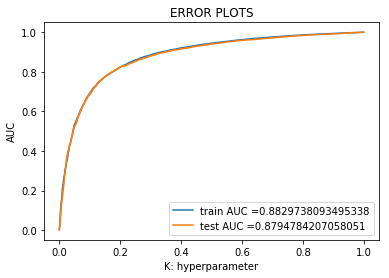

In [65]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = MultinomialNB(alpha=0.1)
neigh.fit(X_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
y_pred = neigh.predict_proba(X_test)

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()



Train data confusion matrix


Text(0.5,1,'Confusion Matrix')

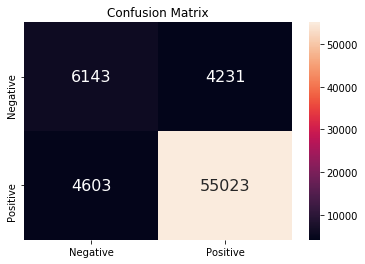

In [66]:
from sklearn.metrics import confusion_matrix
#Tain data
print("Train data confusion matrix")
conf_matrix = confusion_matrix(y_train,neigh.predict(X_train))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [67]:
from sklearn.metrics import  classification_report
print (classification_report(y_train,neigh.predict(X_train)))

             precision    recall  f1-score   support

          0       0.57      0.59      0.58     10374
          1       0.93      0.92      0.93     59626

avg / total       0.88      0.87      0.87     70000



Test data confusion matrix


Text(0.5,1,'Confusion Matrix')

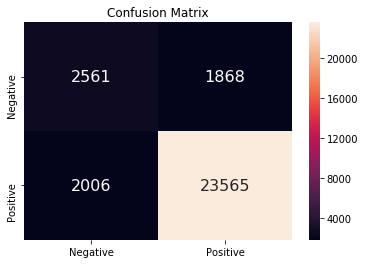

In [68]:
from sklearn.metrics import confusion_matrix
#Test data
print("Test data confusion matrix")
conf_matrix = confusion_matrix(y_test,neigh.predict(X_test))
cf_matrix = pd.DataFrame(conf_matrix,["Negative","Positive"],
                        ["Negative","Positive"],
                         dtype=int)
sns.heatmap(cf_matrix,annot=True,annot_kws={"size": 16}, fmt='g')
plt.title('Confusion Matrix')

In [69]:
from sklearn.metrics import  classification_report
print (classification_report(y_test,neigh.predict(X_test)))

             precision    recall  f1-score   support

          0       0.56      0.58      0.57      4429
          1       0.93      0.92      0.92     25571

avg / total       0.87      0.87      0.87     30000



# Conclusions-

1. So by performing Naive Bayes for Bow and Tfidf we got higher accraccy for Tfidf
2. Accuraccy might be differ or increase by taking all data 
3. So by performing feature Engineering model accuraccy gets increase.